In [7]:
# imports
import pandas as pd 
import numpy as np
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import datasets
import torch.optim as optim
import random as rn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d (What are you? An alien that can visualise >3d?). Make sure the "dimensions" argument is in (2, 3)')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=RANDOM_SEED).fit_transform(features)
    
    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))

     # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    # plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='Fraud'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Clean'
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show;

In [ ]:
class CreditDataset(Dataset):
    def __init__(self, data):
        self.data_transformed = data

    def __len__(self):
        return len(self.data_transformed)

    def __getitem__(self, idx):
        return self.data_transformed[idx]

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        #^inherits from model
        self.encode1 = nn.Linear(input_dim, input_dim)
        self.encode2 = nn.Linear(input_dim, 16)
        self.encode3 = nn.Linear(16, 8)
        self.encode4 = nn.Linear(8, 4)
        self.encode5 = nn.Linear(4, 2)
        self.decode1 = nn.Linear(2, 4)
        self.decode2 = nn.Linear(4, 8)
        self.decode3 = nn.Linear(8, 16)
        self.decode4 = nn.Linear(16, input_dim)

    def forward(self, x):
        x = F.elu(self.encode1(x))
        x = F.elu(self.encode2(x))
        x = F.elu(self.encode3(x))
        x = F.elu(self.encode4(x))
        x = F.elu(self.encode5(x))
        x = F.elu(self.decode1(x))
        x = F.elu(self.decode2(x))
        x = F.elu(self.decode3(x))
        x = F.elu(self.decode4(x))

        return x

In [12]:
# visualisations
sns.set(style='whitegrid', context='notebook')
%matplotlib notebook

In [13]:
# manual parameters
RANDOM_SEED = 42
TRAINING_SAMPLE = 200000
VALIDATE_SIZE = 0.2

# setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
#tf.set_random_seed(RANDOM_SEED)

In [14]:
# load the dataset
df = pd.read_csv('/Users/mayabridgman/OneDrive - Dubai College/credit card/creditcard.csv')

In [16]:
# convert columns to lower case to avoid syntax errors
df.columns = map(str.lower, df.columns)
df.rename(columns={'class': 'label'}, inplace=True)

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [17]:
# avoid taking log of 0
df['log10_amount'] = np.log10(df.amount + 0.00001)

In [18]:
np.log10(100010001000111)

14.000043431619856

In [19]:
#testing
np.log10(0)
np.log10(0.001)

/Users/mayabridgman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


-inf

In [21]:
# manual parameter 
RATIO_TO_FRAUD = 15

# dropping redundant columns
df = df.drop(['time', 'amount'], axis=1)

# splitting by class
fraud = df[df.label == 1]
clean = df[df.label == 0]

# undersample clean transactions
clean_undersampled = clean.sample(
    int(len(fraud) * RATIO_TO_FRAUD),
    random_state=RANDOM_SEED
)

# concatenate into a single dataframe
visualisation_initial = pd.concat([fraud, clean_undersampled])
column_names = list(visualisation_initial.drop('label', axis=1).columns)

# isolate features from labels 
features, labels = visualisation_initial.drop('label', axis=1).values, \
                   visualisation_initial.label.values

In [16]:
#check shapes to make sure all is in order
fraud.shape
clean.shape
clean_undersampled.shape

(492, 29)

In [20]:
tsne_scatter(features, labels, dimensions=2, save_as='tsne_initial_2d.png')

<IPython.core.display.Javascript object>

## splitting and training

In [34]:
# shuffle training set
clean = clean.sample(frac=1).reset_index(drop=True)

# training set = exlusively non-fraud transactions
X_train = clean.iloc[:TRAINING_SAMPLE].drop('label', axis=1)

# testing  set = the remaining non-fraud + all the fraud 
X_test = clean.iloc[TRAINING_SAMPLE:].append(fraud).sample(frac=1)

In [35]:
# train // validate
X_train, X_validate = train_test_split(X_train, 
                                       test_size=VALIDATE_SIZE, 
                                       random_state=RANDOM_SEED)

# splitting the labels from test df
X_test, y_test = X_test.drop('label', axis=1).values, X_test.label.values


In [36]:
# configure pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

In [37]:
# get normalization parameters by fitting to the training data
pipeline.fit(X_train);

In [38]:
# transform the training and validation data with these parameters
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)

In [39]:
X_train_transformed

array([[0.92038934, 0.45419962, 0.36876803, ..., 0.69172755, 0.48482626,
        0.75536945],
       [0.578862  , 0.53949244, 0.53807554, ..., 0.62810739, 0.42931326,
        0.73624146],
       [0.73205263, 0.43524952, 0.61049829, ..., 0.66078918, 0.4984287 ,
        0.79974158],
       ...,
       [0.51978756, 0.64972147, 0.54374784, ..., 0.67039943, 0.49944296,
        0.78674441],
       [0.27539742, 0.82575138, 0.53464652, ..., 0.67324585, 0.43734802,
        0.70568326],
       [0.88029998, 0.51687406, 0.21399165, ..., 0.65752125, 0.4734861 ,
        0.7213179 ]])

In [42]:
X_test_transformed = pipeline.transform(X_test)

In [43]:
training_data = CreditDataset(X_train_transformed)
validate_data = CreditDataset(X_validate_transformed)
test_data = CreditDataset(X_test_transformed)

In [44]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
validate_dataloader = DataLoader(validate_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [45]:
next(iter(train_dataloader)).shape
next(iter(validate_dataloader)).shape

torch.Size([64, 29])

In [46]:
type(next(iter(train_dataloader)))
type(next(iter(validate_dataloader)))

torch.Tensor

In [47]:
next(iter(train_dataloader)).shape
next(iter(validate_dataloader)).shape

torch.Size([64, 29])

In [49]:
input_dim = X_train_transformed.shape[1]
net = Net(input_dim)

In [50]:
net(next(iter(train_dataloader)).float())

tensor([[-0.2532,  0.1643, -0.1746,  ...,  0.0060,  0.2519, -0.1867],
        [-0.2527,  0.1643, -0.1743,  ...,  0.0064,  0.2514, -0.1867],
        [-0.2518,  0.1643, -0.1739,  ...,  0.0073,  0.2508, -0.1866],
        ...,
        [-0.2520,  0.1643, -0.1740,  ...,  0.0070,  0.2510, -0.1866],
        [-0.2531,  0.1643, -0.1746,  ...,  0.0061,  0.2518, -0.1867],
        [-0.2522,  0.1643, -0.1741,  ...,  0.0069,  0.2511, -0.1866]],
       grad_fn=<EluBackward>)

In [51]:
#MSE for calculating loss
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [52]:
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs]
        inputs= data.float()

        # zero the parameter gradients
        net.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.056
[2,  2000] loss: 0.017
[3,  2000] loss: 0.017
[4,  2000] loss: 0.017
[5,  2000] loss: 0.017
[6,  2000] loss: 0.017
[7,  2000] loss: 0.017
[8,  2000] loss: 0.017
[9,  2000] loss: 0.017
[10,  2000] loss: 0.017
[11,  2000] loss: 0.017
[12,  2000] loss: 0.017
[13,  2000] loss: 0.017
[14,  2000] loss: 0.017
[15,  2000] loss: 0.017
[16,  2000] loss: 0.017
[17,  2000] loss: 0.017
[18,  2000] loss: 0.017
[19,  2000] loss: 0.017
[20,  2000] loss: 0.017
[21,  2000] loss: 0.017
[22,  2000] loss: 0.017
[23,  2000] loss: 0.017
[24,  2000] loss: 0.017
[25,  2000] loss: 0.017
[26,  2000] loss: 0.017
[27,  2000] loss: 0.017
[28,  2000] loss: 0.017
[29,  2000] loss: 0.017
[30,  2000] loss: 0.017
[31,  2000] loss: 0.017
[32,  2000] loss: 0.017
[33,  2000] loss: 0.017
[34,  2000] loss: 0.017
[35,  2000] loss: 0.017
[36,  2000] loss: 0.017
[37,  2000] loss: 0.017
[38,  2000] loss: 0.017
[39,  2000] loss: 0.017
[40,  2000] loss: 0.017
[41,  2000] loss: 0.017
[42,  2000] loss: 0.017
[

In [58]:
torch.save(net.state_dict(), "***/credit card/autoencoder")

In [59]:
net_reloaded = Net(input_dim)
net_reloaded.load_state_dict(torch.load("***/credit card/autoencoder"))
net_reloaded.eval()

Net(
  (encode1): Linear(in_features=29, out_features=29, bias=True)
  (encode2): Linear(in_features=29, out_features=16, bias=True)
  (encode3): Linear(in_features=16, out_features=8, bias=True)
  (encode4): Linear(in_features=8, out_features=4, bias=True)
  (encode5): Linear(in_features=4, out_features=2, bias=True)
  (decode1): Linear(in_features=2, out_features=4, bias=True)
  (decode2): Linear(in_features=4, out_features=8, bias=True)
  (decode3): Linear(in_features=8, out_features=16, bias=True)
  (decode4): Linear(in_features=16, out_features=29, bias=True)
)

In [54]:
accumulated = []

for i, data in enumerate(test_dataloader, 0):
    # get the inputs; data is a list of [inputs]
    inputs= data.float()

    #no need to tweak weights more - frozen
    with torch.no_grad():
        outputs = net(inputs)
        accumulated.append(outputs)

In [56]:
len(accumulated[-2])
accumulated = np.vstack(accumulated)

In [60]:
#test_loss = criterion(torch.tensor(accumulated), X_test_transformed)
test_loss = np.mean(np.power(X_test_transformed - accumulated, 2), axis=1)

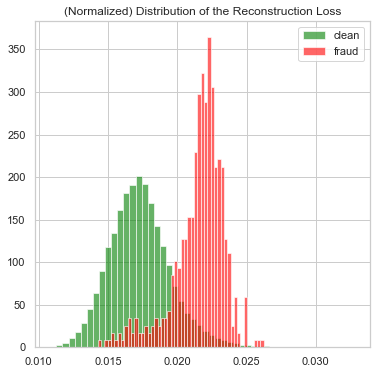

In [65]:
%matplotlib inline
clean = test_loss[y_test==0]
fraud = test_loss[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()